In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#dfStats = gp.read_file("regression_results/ols_run_tdx2.gpkg")
dfStats = gp.read_file("regression_results/test.gpkg")
rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")

In [22]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,regression.const.se,regression.count,regression.robust.c,regression.robust.c.se,regression.robust.c.year,regression.robust.c.se.year,regression.robust.const,regression.robust.const.se,regression.robust.count,geometry
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,67,"-1,536,372.748238","-21,292.235597",...,19.145310,106.000000,0.000000,0.000000,2.008401,0.450894,-112.057941,20.080182,106.000000,POINT (-1550000 -50000)
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,0,"-1,443,185.584551","29,895.766148",...,nan,nan,nan,nan,nan,nan,nan,nan,nan,POINT (-1450000 50000)
2,-1500000,400000,100000,10.772159,107.072272,2003,-15.974319,305,"-1,440,701.926815","459,939.024227",...,10.270468,"2,003.000000",-0.000000,0.000000,-0.107546,0.216630,-9.257380,9.698364,"2,003.000000",POINT (-1450000 450000)
3,-1400000,0,100000,23.879357,63.412965,2053,-10.438546,1346,"-1,339,945.336884","57,970.013154",...,8.510609,"2,053.000000",0.000000,0.000000,0.383465,0.147026,-26.456381,6.618186,"2,053.000000",POINT (-1350000 50000)
4,-1400000,100000,100000,2.365825,11.978117,151,-17.005372,92,"-1,337,447.302104","131,513.591615",...,30.234220,151.000000,-0.000000,0.000000,-2.041078,0.521104,72.878113,23.094871,151.000000,POINT (-1350000 150000)


In [23]:
dfStats.columns

Index(['gridCell.minX', 'gridCell.minY', 'gridCell.size',
       'statistics.DebrisMaskArea', 'statistics.GlacierMaskArea',
       'statistics.afterGlacierMask', 'statistics.meanElevationDifference',
       'statistics.pointsWithinDebrisMask', 'statistics.result_avgX',
       'statistics.result_avgY', 'statistics.result_count_2010',
       'statistics.result_count_2011', 'statistics.result_count_2012',
       'statistics.result_count_2013', 'statistics.result_count_2014',
       'statistics.result_count_2015', 'statistics.result_count_2016',
       'statistics.result_count_2017', 'statistics.result_count_2018',
       'statistics.result_count_2019', 'statistics.result_offsetX',
       'statistics.result_offsetY', 'statistics.result_refDifference_2010',
       'statistics.result_refDifference_2011',
       'statistics.result_refDifference_2012',
       'statistics.result_refDifference_2013',
       'statistics.result_refDifference_2014',
       'statistics.result_refDifference_2015',
  

In [19]:
dfStats.shape[0]

258

In [24]:
pd.options.display.float_format = '{:20,.6f}'.format
dfStats.mean()

gridCell.minX                                -65,625.000000
gridCell.minY                               -230,078.125000
gridCell.size                                100,000.000000
statistics.DebrisMaskArea                         37.640154
statistics.GlacierMaskArea                       350.127410
statistics.afterGlacierMask                   10,974.992188
statistics.meanElevationDifference                -9.585567
statistics.pointsWithinDebrisMask                467.242188
statistics.result_avgX                       -15,830.485725
statistics.result_avgY                      -178,354.980504
statistics.result_count_2010                     389.058594
statistics.result_count_2011                   1,254.085938
statistics.result_count_2012                   1,357.781250
statistics.result_count_2013                   1,350.492188
statistics.result_count_2014                   1,309.359375
statistics.result_count_2015                   1,312.609375
statistics.result_count_2016            

In [3]:
%matplotlib notebook
#plt.hist(x=dfStats['statistics.GlacierMaskArea'], bins=50)
dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 10
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 30
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 60
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 90
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 130
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 165

<IPython.core.display.Javascript object>


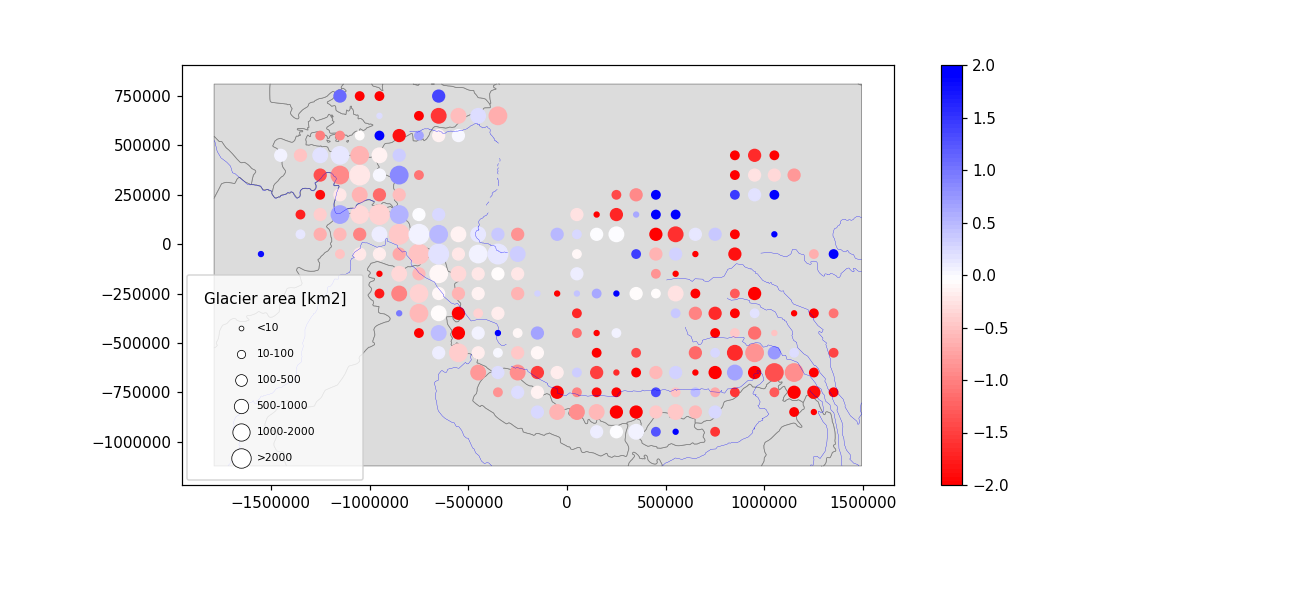

In [4]:
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
#msf = 170
#markersize = (dfStatsfiltered['statistics.GlacierMaskArea'])*msf
markersize = dfStatsfiltered['statistics.GlacierMaskArea.pointsize']
dfStatsfiltered.plot(ax=ax, column='regression.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

#labels = ["0.05", "0.10", "0.20", "0.30"]
#sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
#print(sizes)
labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [10, 30, 60, 90, 130, 165]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

#for i, txt in enumerate(dfStatsfiltered['regression.count']):
    #print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
    #if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
    #    ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
    #                           (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
    #                           (size/2)+10000), fontsize=5)
#for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
#    print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


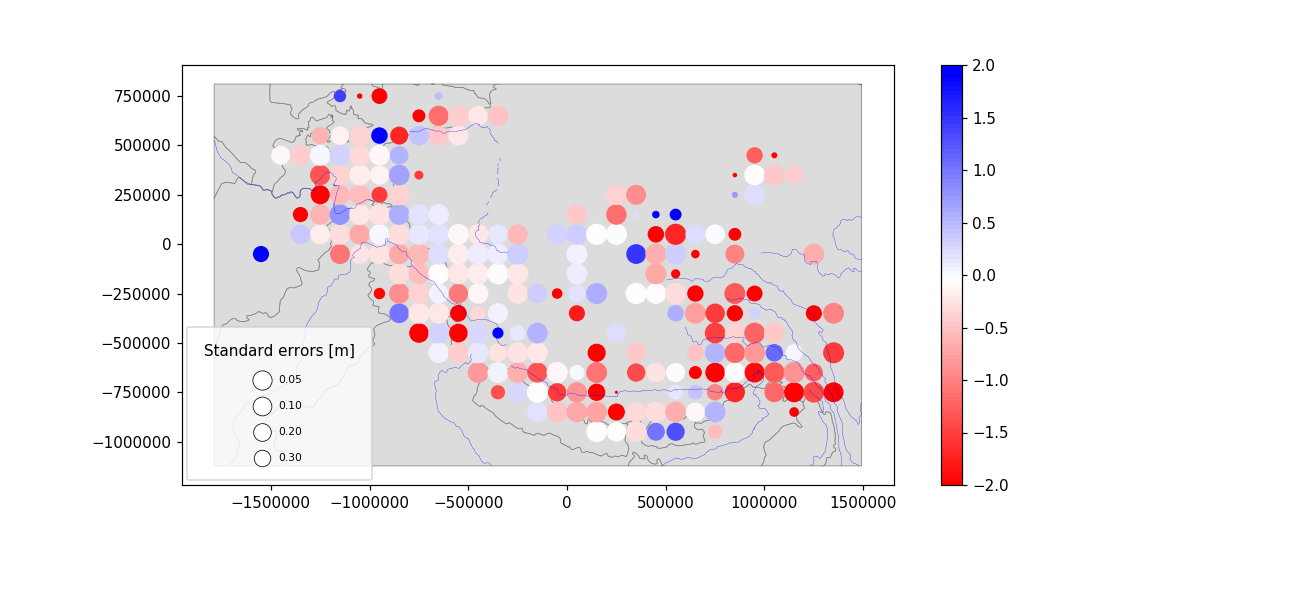

[161.5, 153.0, 136.0, 118.99999999999999]


/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [5]:
#ROBUST
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.robust.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
msf = 170
markersize = (1-dfStatsfiltered['regression.robust.c.se.year'])*msf
dfStatsfiltered.plot(ax=ax, column='regression.robust.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors [m]', scatterpoints = 1, labelspacing=1.5)

#for i, txt in enumerate(dfStatsfiltered['regression.count']):
    #print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
    #if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
    #    ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
    #                           (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
    #                           (size/2)+10000), fontsize=5)
#for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
#    print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)
print(sizes)

<IPython.core.display.Javascript object>


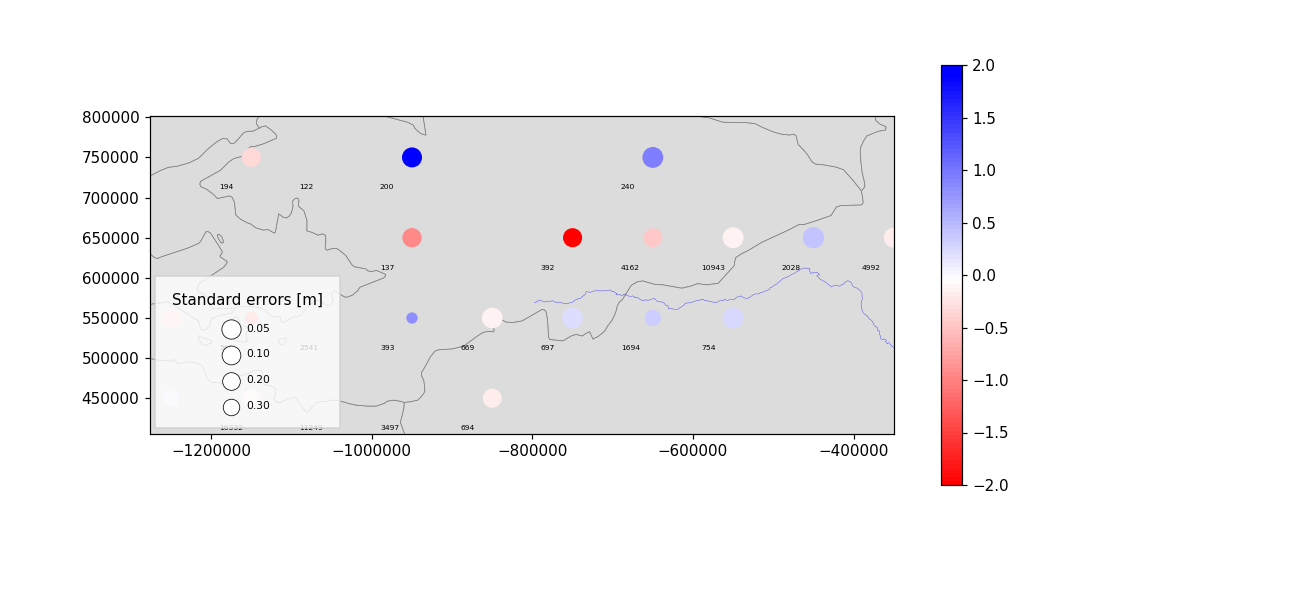

In [31]:
%matplotlib notebook
# DIFFERENCE between linear and robust

dfStats['regression.c.difference'] = dfStats['regression.c.year']-dfStats['regression.robust.c.year']
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)

vmin=-2
vmax=2

msf = 170
markersize = (1-dfStatsfiltered['regression.c.se.year'])*msf
dfStats.plot(ax=ax, column='regression.c.difference', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors [m]', scatterpoints = 1, labelspacing=1.5)

for i, txt in enumerate(dfStats['regression.count']):
    if dfStats.loc[dfStats.index[i], 'statistics.afterGlacierMask'] > 50:
        ax.annotate(int(txt), (dfStats.loc[dfStats.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfStats.loc[dfStats.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


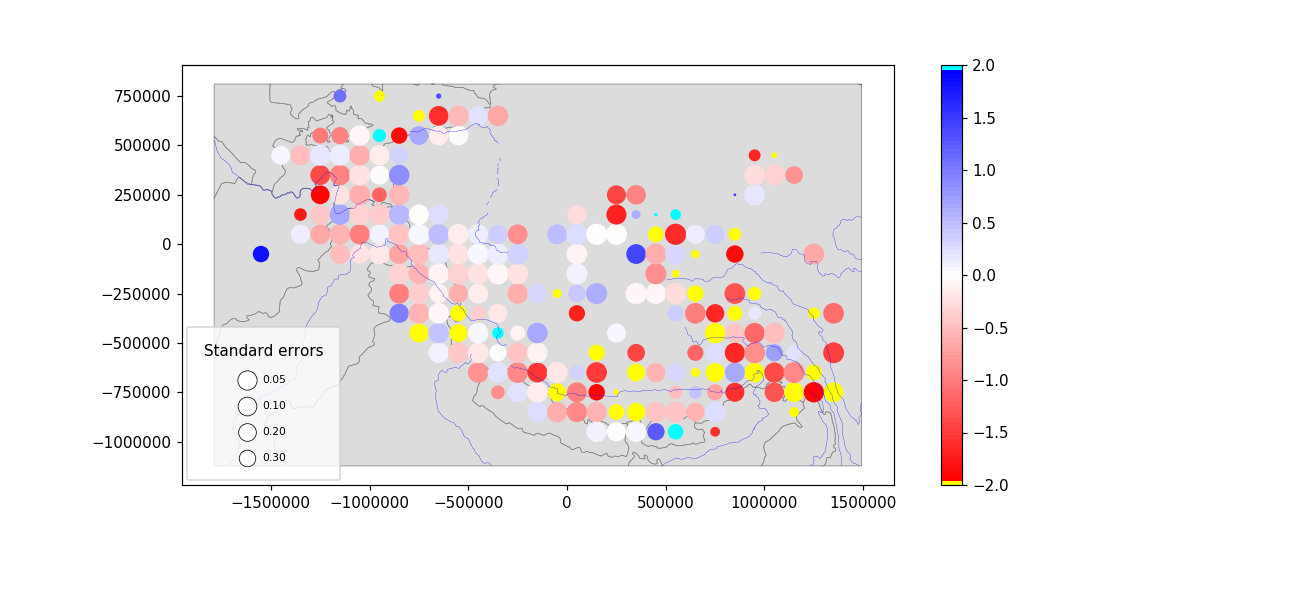

In [26]:
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',[(1, 1, 0)]+list(map(cm_,range(98)))+[(0, 1, 1)], N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
msf = 170
markersize = (1-dfStatsfiltered['regression.c.se.year'])*msf
dfStatsfiltered.plot(ax=ax, column='regression.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors', scatterpoints = 1, labelspacing=1.5)



#for i, txt in enumerate(dfStatsfiltered['regression.count']):
    #print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
    #if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
    #    ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
    #                           (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
    #                           (size/2)+10000), fontsize=5)
#for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
#    print(dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'])
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


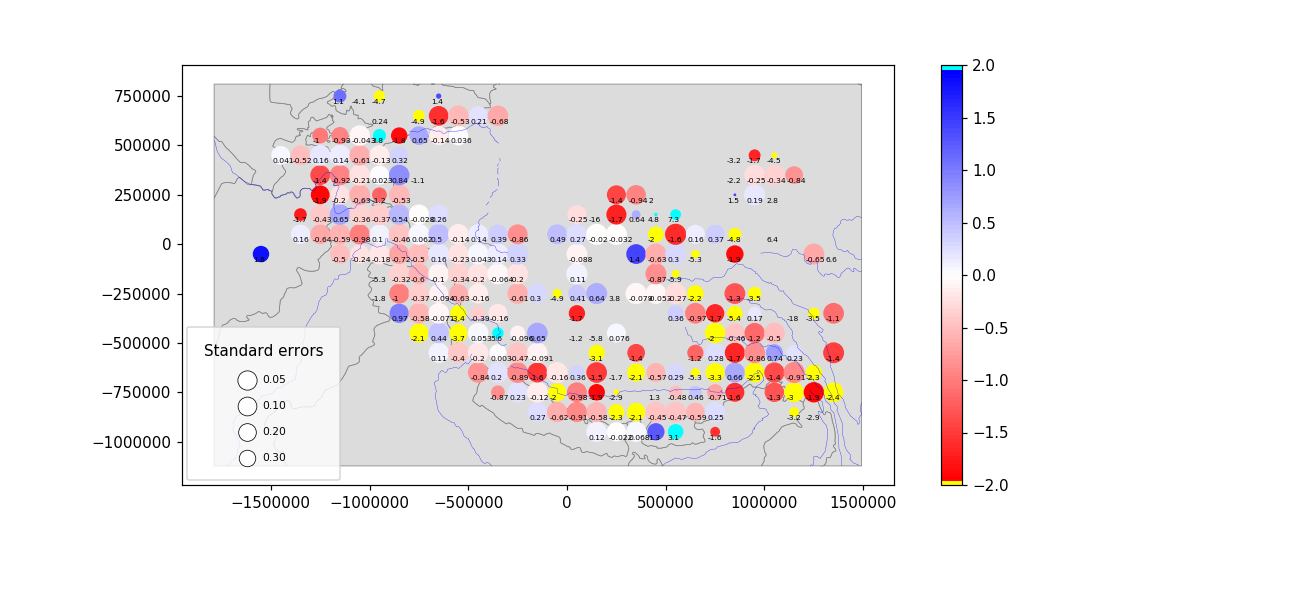

In [27]:
%matplotlib notebook


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',[(1, 1, 0)]+list(map(cm_,range(98)))+[(0, 1, 1)], N=100)

#dfStatsfiltered = dfStats[(dfStats['regression.c.se.year'] <= 0.20)]
dfStatsfiltered = dfStats[(dfStats['regression.count'] > 50)]
vmin=-2
vmax=2
fig, ax = plt.subplots(figsize=(11,5))

# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)


#markersize = dfStats['regression.count']/100
msf = 170
markersize = (1-dfStatsfiltered['regression.c.se.year'])*msf
dfStatsfiltered.plot(ax=ax, column='regression.c.year', markersize=markersize, legend=True, vmin=vmin, \
                     vmax=vmax, cmap=cm)

labels = ["0.05", "0.10", "0.20", "0.30"]
sizes = [(1-0.05)*msf, (1-0.10)*msf, (1-0.20)*msf, (1-0.30)*msf]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Standard errors', scatterpoints = 1, labelspacing=1.5)

#for i, txt in enumerate(dfStatsfiltered['regression.count']):
#    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
#        ax.annotate(int(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)
for i, txt in enumerate(dfStatsfiltered['regression.c.year']):
    if dfStatsfiltered.loc[dfStatsfiltered.index[i], 'statistics.afterGlacierMask'] > 50:
        ax.annotate('{0:.2g}'.format(txt), (dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfStatsfiltered.loc[dfStatsfiltered.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


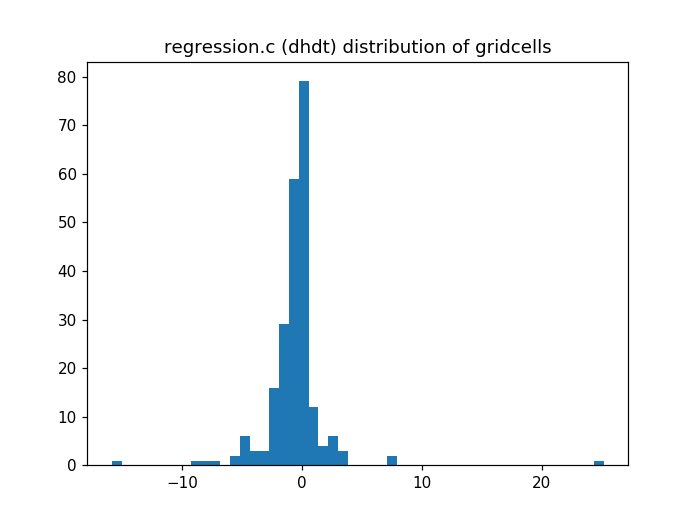

In [16]:
%matplotlib notebook
plt.hist(dfStatsfiltered['regression.c.year'], bins=50)
plt.title('regression.c (dhdt) distribution of gridcells')
plt.show()

<IPython.core.display.Javascript object>


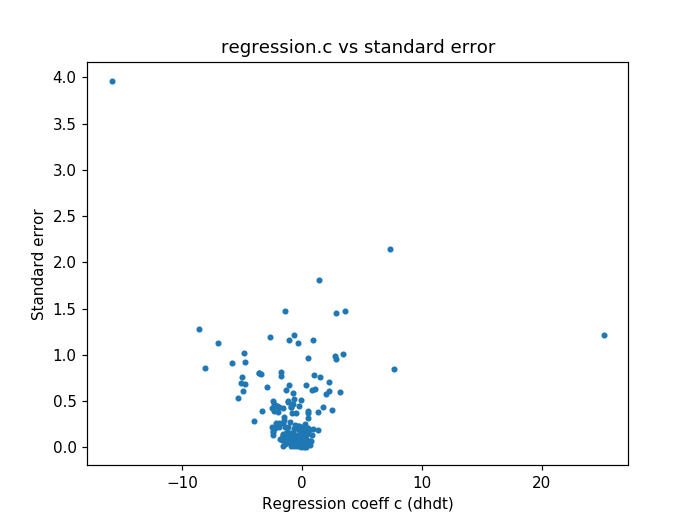

In [17]:
%matplotlib notebook
plt.scatter(dfStatsfiltered['regression.c.year'],dfStatsfiltered['regression.c.se.year'], marker='.')
plt.title('regression.c vs standard error')
plt.xlabel('Regression coeff c (dhdt)')
plt.ylabel('Standard error')
plt.show()

<IPython.core.display.Javascript object>


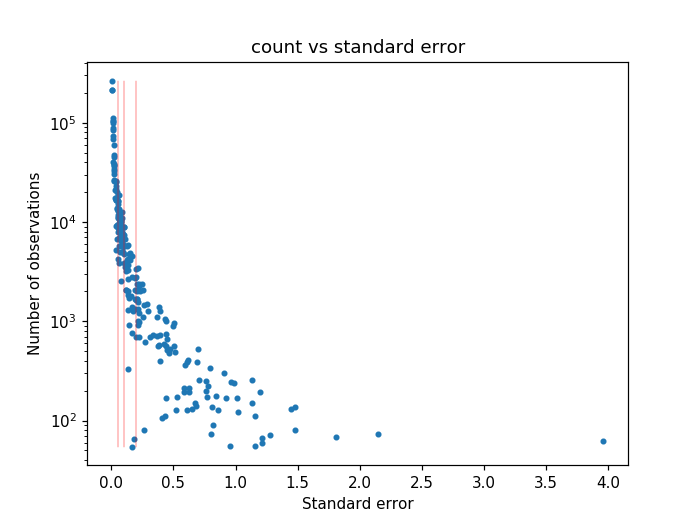

In [18]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.scatter(dfStatsfiltered['regression.c.se.year'],dfStatsfiltered['regression.count'], marker='.')
ymax=dfStatsfiltered['regression.count'].max()
ymin=dfStatsfiltered['regression.count'].min()
plt.plot([0.05,0.05],[ymin,ymax], '-r', linewidth=0.3)
plt.plot([0.1,0.1],[ymin,ymax], '-r', linewidth=0.3)
plt.plot([0.2,0.2],[ymin,ymax], '-r', linewidth=0.3)
plt.title('count vs standard error')
plt.ylabel('Number of observations')
plt.xlabel('Standard error')
ax.set_yscale('log')
plt.show()

<IPython.core.display.Javascript object>


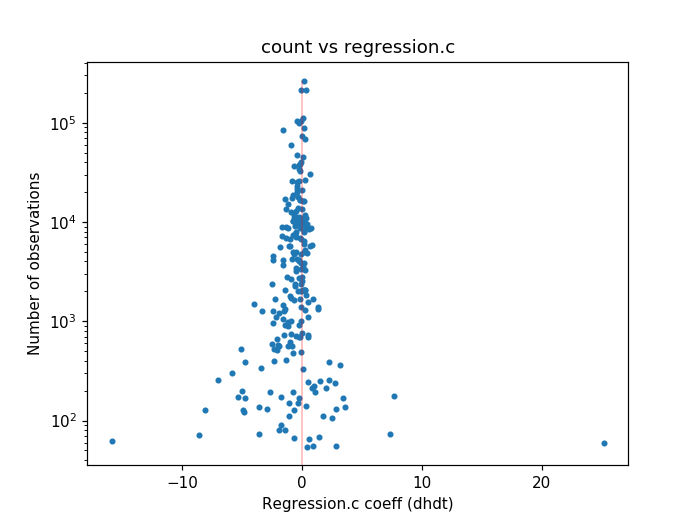

In [19]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.scatter(dfStatsfiltered['regression.c.year'],dfStatsfiltered['regression.count'], marker='.')
ymax=dfStatsfiltered['regression.count'].max()
plt.plot([0,0],[0,ymax], '-r', linewidth=0.3)
plt.title('count vs regression.c')
plt.ylabel('Number of observations')
plt.xlabel('Regression.c coeff (dhdt)')
ax.set_yscale('log')
plt.show()